In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext notexbook
%texify

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cellbgnet
import cellbgnet.utils
from cellbgnet.datasets import DataSimulator
from cellbgnet.utils.hardware import cpu, gpu
from cellbgnet.model import CellBGModel
from cellbgnet.simulation.psf_kernel import SMAPSplineCoefficient
from cellbgnet.generic.emitter import EmitterSet
from cellbgnet.train_loss_infer import generate_probmap_cells
from skimage.io import imread
from skimage.measure import label
import random
import edt
from skimage.filters import gaussian
from skimage import segmentation
from scipy.ndimage import rotate
import random
import pickle
import pathlib
from pathlib import Path
#matplotlib qt5

In [3]:
param_file = '../../cellbgnet/utils/reference_files/reference.yaml'
param = cellbgnet.utils.param_io.ParamHandling().load_params(param_file)

In [4]:
psf_params = param.PSF.to_dict()
simulation_params = param.Simulation.to_dict()
hardware_params = param.Hardware.to_dict()
train_size = simulation_params['train_size']
with open(param.Simulation.edt_noise_map_path, 'rb') as fp:
    edt_noise_map = pickle.load(fp)

model = cellbgnet.model.CellBGModel(param);

training sliding windows on camera chip:
Area num: 0, field_xy: [0, 127, 0, 127]
Area num: 1, field_xy: [114, 241, 0, 127]
Area num: 2, field_xy: [228, 355, 0, 127]
Area num: 3, field_xy: [342, 469, 0, 127]
Area num: 4, field_xy: [456, 583, 0, 127]
Area num: 5, field_xy: [570, 697, 0, 127]
Area num: 6, field_xy: [684, 811, 0, 127]
Area num: 7, field_xy: [798, 925, 0, 127]
Area num: 8, field_xy: [912, 1039, 0, 127]
Area num: 9, field_xy: [1026, 1153, 0, 127]
Area num: 10, field_xy: [1140, 1267, 0, 127]
Area num: 11, field_xy: [1174, 1301, 0, 127]
Area num: 12, field_xy: [0, 127, 114, 241]
Area num: 13, field_xy: [114, 241, 114, 241]
Area num: 14, field_xy: [228, 355, 114, 241]
Area num: 15, field_xy: [342, 469, 114, 241]
Area num: 16, field_xy: [456, 583, 114, 241]
Area num: 17, field_xy: [570, 697, 114, 241]
Area num: 18, field_xy: [684, 811, 114, 241]
Area num: 19, field_xy: [798, 925, 114, 241]
Area num: 20, field_xy: [912, 1039, 114, 241]
Area num: 21, field_xy: [1026, 1153, 114, 24

#### Generate one simulation stack

In [5]:
random_filename = random.choice(model.data_generator.cell_mask_filenames)
random_cell_mask = imread(random_filename)
random_cell_mask = segmentation.expand_labels(random_cell_mask, distance=1)
non_cell_density = model.simulation_params['non_cell_density']
density = model.simulation_params['density']
train_size = 128
prob_map, cell_masks_batch = generate_probmap_cells(random_cell_mask, model.batch_size, train_size, density, 
                                                    non_cell_density, model.simulation_params['margin_empty'], False)

In [6]:
prob_map.shape, cell_masks_batch.shape, prob_map.dtype, cell_masks_batch.dtype

((16, 128, 128), (16, 128, 128), dtype('float64'), dtype('float64'))

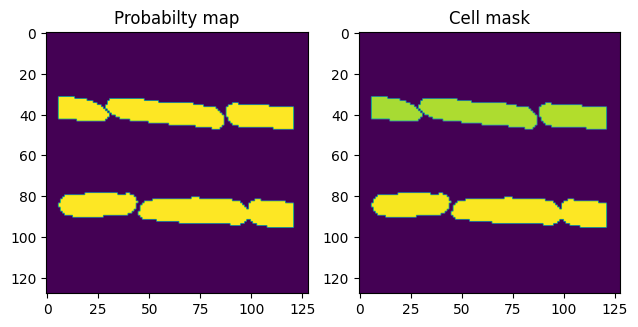

In [7]:
index = 10
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(prob_map[index])
ax[0].set_title("Probabilty map")
ax[1].imshow(cell_masks_batch[index])
ax[1].set_title("Cell mask")
plt.tight_layout()
plt.show()

In [8]:
imgs_sim, xyzi_gt, s_mask, psf_imgs_gt, locs, field_xy = model.data_generator.simulate_data(
        prob_map=gpu(prob_map), batch_size=model.batch_size, 
        local_context=False, photon_filter=model.train_params['photon_filter'],
        photon_filter_threshold=model.train_params['photon_filter_threshold'],
        P_locs_cse=model.train_params['P_locs_cse'],
        iter_num=model._iter_count, train_size=train_size,
        robust_training=model.data_generator.simulation_params['robust_training'],
        cell_masks=cell_masks_batch
)

/home/pk/Documents/cellbgnet/cellbgnet/utils/hardware.py:9: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  return torch.cuda.FloatTensor(x.astype('float32'))


In [9]:
imgs_sim.shape, xyzi_gt.shape, s_mask.shape, psf_imgs_gt.shape, locs.shape, field_xy

(torch.Size([16, 1, 128, 128]),
 torch.Size([16, 14, 4]),
 torch.Size([16, 14]),
 torch.Size([16, 128, 128]),
 torch.Size([16, 128, 128]),
 tensor([  0, 127,   0, 127]))

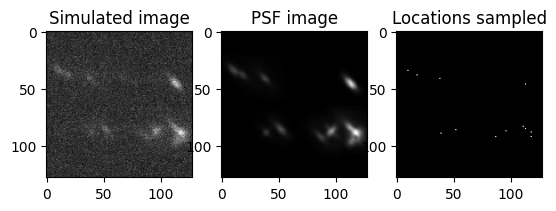

In [10]:

fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(imgs_sim[index][0].cpu().numpy(), cmap='gray')
ax[0].set_title("Simulated image")
ax[1].imshow(psf_imgs_gt[index].cpu().numpy(), cmap='gray')
ax[1].set_title("PSF image")
ax[2].imshow(locs[index].cpu().numpy(), cmap='gray')
ax[2].set_title('Locations sampled')

plt.show()

##### Run the model and the print output shapes

In [11]:
# These are the outputs predicted by the network
P, xyzi_est, xyzi_sig_est, psf_imgs_est = model.inferring(imgs_sim, field_xy, 
                                        camera_chip_size=[model.data_generator.camera_chip_size[1], 
                                                          model.data_generator.camera_chip_size[0]])

In [12]:
P.shape, xyzi_est.shape, xyzi_sig_est.shape, psf_imgs_est.shape

(torch.Size([16, 128, 128]),
 torch.Size([16, 4, 128, 128]),
 torch.Size([16, 4, 128, 128]),
 torch.Size([16, 128, 128]))

In [13]:

loss_total, (count_loss, loc_loss, bg_loss, P_locs_error) = model.final_loss(P, xyzi_est, xyzi_sig_est,
                                                                             xyzi_gt, s_mask, psf_imgs_est, psf_imgs_gt, locs)

# Decompose different components


### Count loss

For each image the sum of probabilities should be equal to the number of emitters in the image. Sum of a bunch of independant bernoulli distributions approximates to a guassian with some mean \begin{equation} \mu = \sum_{k=1}^{K}{\hat{p}_{k}}  \end{equation} 

and

\begin{equation} 
\sigma^{2} = \sum_{k=1}^{K}{\hat{p}_{k} (1 - \hat{p}_{k})}
\end{equation}

https://stats.stackexchange.com/questions/93852/sum-of-bernoulli-variables-with-different-success-probabilities

\begin{equation}
\mathcal{L}_{count}=-\log P(E|\mu_{count}, \sigma^2_{count})= \log(\sqrt{2\pi \sigma_{count}})+ \frac{1}{2}\frac{(E-\mu_{count})^2}{\sigma^2_{count}}
\end{equation}


In [14]:
prob_mean = P.sum(-1).sum(-1) # one per image in the batch
prob_var = (P - P **2).sum(-1).sum(-1)
X = s_mask.sum(-1) # each image has different number of emitters, X is the number of emitters sampled in an image
print(f"Number of emitters in each image of the batch: {X}")
count_loss = 1 / 2 * ((X - prob_mean) ** 2) / prob_var + 1 / 2 * torch.log(2 * np.pi * prob_var)


Number of emitters in each image of the batch: tensor([ 5.,  0.,  9.,  6.,  1.,  3.,  6., 13., 10.,  6., 12.,  8.,  6., 14.,
        10., 13.], device='cuda:0')


#### Molecule loss

Mean square error between psf_imgs in ground truth and esitmate


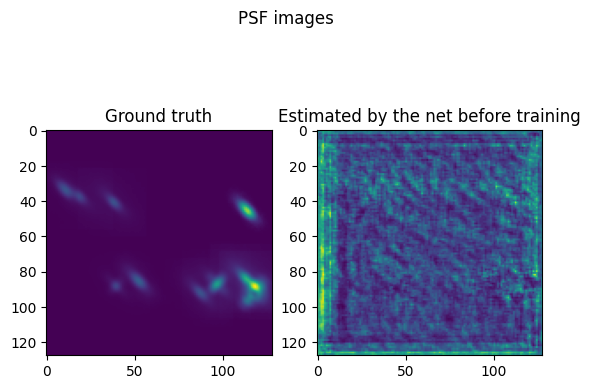

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(psf_imgs_gt[index].detach().cpu().numpy())
ax[0].set_title("Ground truth")
ax[1].imshow(psf_imgs_est[index].detach().cpu().numpy())
ax[1].set_title("Estimated by the net before training")
plt.suptitle("PSF images")
plt.show()


\begin{equation}
    \mathcal{L}_{Mol} = \sum_{k=1}^{K} (\hat{I}_k - I_k)^2,
\end{equation}


In [16]:
molecule_loss = torch.nn.MSELoss(reduction='none')
molecule_loss_value = molecule_loss(psf_imgs_est, psf_imgs_gt)
print(molecule_loss_value.shape)
molecule_loss_value = molecule_loss_value.sum(-1).sum(-1)
print(molecule_loss_value.shape) # one for each image in the batch

torch.Size([16, 128, 128])
torch.Size([16])


#### Cross-entropy loss

In [17]:
P.shape, locs.shape

(torch.Size([16, 128, 128]), torch.Size([16, 128, 128]))



\begin{equation}
\mathcal{L}_{CE} = \sum_{k=1}^{K}-\left[p_{k} \log \hat{p}_{k} + (1 - p_{k}) \log (1- \hat{p}_{k})\right]
\end{equation}



In [18]:
loss_cse = -(locs * torch.log(P) + (1 - locs) * torch.log(1 - P))
loss_cse = loss_cse.sum(-1).sum(-1)

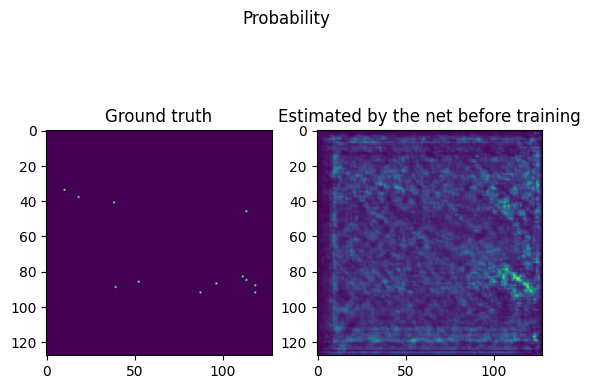

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(locs[index].detach().cpu().numpy())
ax[0].set_title("Ground truth")
ax[1].imshow(P[index].detach().cpu().numpy())
ax[1].set_title("Estimated by the net before training")
plt.suptitle("Probability")
plt.show()

#### Localization loss (The hard one to understand)

In [20]:
P.shape, P.device

(torch.Size([16, 128, 128]), device(type='cuda', index=0))

In [21]:
xyzi_sig_est.shape

torch.Size([16, 4, 128, 128])

#### Calculate the log of this for every ground truth emitter in the image

\begin{equation}
P(\boldsymbol{u}^{GT}_{e} | \boldsymbol{\mu}_{k}, \Sigma_{k}) = \frac{1}{\sqrt{(2\pi)^4}det(\Sigma_{k})} \exp \biggl(-\frac{1}{2}(\boldsymbol{\hat{\mu}}_{k} - \mathbf{u^{GT}})^T \hat{\Sigma}^{-1}_{k}(\boldsymbol{\hat{\mu}}_{k} - \mathbf{u^{GT}})\biggr)
\end{equation}

In [22]:
p_inds = tuple((P + 1).nonzero().transpose(1, 0)) 

xyzi_mu = xyzi_est[p_inds[0], :, p_inds[1], p_inds[2]] # these are offsets from the center of the pixel
xyzi_mu[:, 0] += p_inds[2].type(torch.cuda.FloatTensor) # make it global by adding (pixel center number)
xyzi_mu[:, 1] += p_inds[1].type(torch.cuda.FloatTensor) # these 2 lines make xyzi_mu from the origin of the image
xyzi_mu_reshaped = xyzi_mu.reshape(model.batch_size, 1, -1, 4)


XYZI_reshaped = xyzi_gt.reshape(model.batch_size, -1, 1, 4).repeat_interleave(model.train_size * model.train_size, 2)
numerator = -1 / 2 * ((XYZI_reshaped - xyzi_mu_reshaped) ** 2)
xyzi_sig_est_indexed = xyzi_sig_est[p_inds[0], :, p_inds[1], p_inds[2]].reshape(model.batch_size, 1, -1, 4)  # >=0.01
denominator = (xyzi_sig_est_indexed ** 2)  # >0
log_p_gauss_4d = (numerator / denominator).sum(3) - 1 / 2 * (torch.log(2 * np.pi * denominator[:, :, :, 0]) +
                                                             torch.log(2 * np.pi * denominator[:, :, :, 1]) +
                                                             torch.log(2 * np.pi * denominator[:, :, :, 2]) +
                                                             torch.log(2 * np.pi * denominator[:, :, :, 3]))


In [23]:
xyzi_mu.shape, XYZI_reshaped.shape, numerator.shape, xyzi_sig_est.shape, denominator.shape, log_p_gauss_4d.shape

(torch.Size([262144, 4]),
 torch.Size([16, 14, 16384, 4]),
 torch.Size([16, 14, 16384, 4]),
 torch.Size([16, 4, 128, 128]),
 torch.Size([16, 1, 16384, 4]),
 torch.Size([16, 14, 16384]))

\begin{equation}
\mathcal{L}_{loc} = - \frac{1}{E} \sum_{e=1}^{E}\log \biggl(\sum_{k=1}^{K}\frac{\hat{p}_k}{\sum_{j=1}^{K} \hat{p}_{j}} P(\mathbf{u}^{GT}_{e} | \boldsymbol{\mu}_{k}, \Sigma_{k}) \biggr),
\end{equation}

#### Compute the log of this and add the terms inside the log of the above equation


\begin{equation}
\sum_{k=1}^{K} \frac{\hat{p}_k}{\sum_{j=1}^{K} \hat{p}_{j}}
\end{equation}

In [24]:

prob_normed = P / (P.sum(-1).sum(-1)[:, None, None])
gauss_coef = prob_normed.reshape(model.batch_size, 1, model.train_size * model.train_size)
gauss_coef_logits = torch.log(gauss_coef)
gauss_coef_logmax = torch.log_softmax(gauss_coef_logits, dim=2)

gmm_log = torch.logsumexp(log_p_gauss_4d + gauss_coef_logmax, dim=2) # summing over the whole image



In [25]:
gauss_coef_logmax.shape, log_p_gauss_4d.shape, gmm_log.shape

(torch.Size([16, 1, 16384]), torch.Size([16, 14, 16384]), torch.Size([16, 14]))

##### Sum over all the emitters in the batch 
\begin{equation}
- \frac{1}{E} \sum_{e=1}^{E}
\end{equation}

In [26]:
final_loss = (gmm_log * s_mask).sum(-1) 